In [8]:

#initialization
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile, BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy


# import basic plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor

## Problem: 

Create a circuit that output the combinations of elements from [ 5, 6, 7, 8, 9, 1] that add up to 16


## QFT/IQFT

In [9]:
#This part contains the necessary functions for implementing QFT and IQFT

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    """ Swaps the qubits as the order is inverted"""
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [10]:
# Sub-circuit for QFT-gate
nqubits = 5
sub1 = QuantumCircuit(nqubits,name='qft')
qft(sub1,nqubits)
qft_gate = sub1.to_instruction()

#Sub-cricuit for IQFT-gate
sub2 = QuantumCircuit(nqubits,name='iqft')
sub2 = inverse_qft(sub2, nqubits)
iqft_gate = sub2.to_instruction()

## Grover

In [11]:
#Verifies if input qubits are in state [0,1,1,0,1]

grover1 = QuantumCircuit(6, name='oracle_1')

grover1.x(0)
grover1.x(3)
grover1.mcp(pi,[0,1,2,3,4],5)
grover1.x(0)
grover1.x(3)

controlled1 = grover1.to_instruction()
grover1.draw()

┌───┐       ┌───┐
q_0: ┤ X ├─■─────┤ X ├
     └───┘ │     └───┘
q_1: ──────■──────────
           │          
q_2: ──────■──────────
     ┌───┐ │     ┌───┐
q_3: ┤ X ├─■─────┤ X ├
     └───┘ │     └───┘
q_4: ──────■──────────
           │P(π)      
q_5: ──────■──────────

In [12]:
#Verifies if input qubits are in state [0,1,0,1,0]

grover2 = QuantumCircuit(6, name='oracle_1')

grover2.x(0)
grover2.x(2)
grover2.x(4)
grover2.mcp(pi,[0,1,2,3,4],5)
grover2.x(0)
grover2.x(2)
grover2.x(4)

controlled = grover2.to_instruction()
grover2.draw()

┌───┐       ┌───┐
q_0: ┤ X ├─■─────┤ X ├
     └───┘ │     └───┘
q_1: ──────■──────────
     ┌───┐ │     ┌───┐
q_2: ┤ X ├─■─────┤ X ├
     └───┘ │     └───┘
q_3: ──────■──────────
     ┌───┐ │     ┌───┐
q_4: ┤ X ├─■─────┤ X ├
     └───┘ │P(π) └───┘
q_5: ──────■──────────

In [13]:
# Gate that checks the result obtained after the IQFT. Shits the controlled qubit if value is 16 == [0,0,0,0,1] (big endian)

grover3 = QuantumCircuit(6, name='checking')

grover3.x(0)
grover3.x(1)
grover3.x(2)
grover3.x(3)
grover3.mct([0,1,2,3,4],5)
grover3.x(0)
grover3.x(1)
grover3.x(2)
grover3.x(3)

controlled_anc = grover3.to_instruction()
grover3.draw()

┌───┐     ┌───┐
q_0: ┤ X ├──■──┤ X ├
     ├───┤  │  ├───┤
q_1: ┤ X ├──■──┤ X ├
     ├───┤  │  ├───┤
q_2: ┤ X ├──■──┤ X ├
     ├───┤  │  ├───┤
q_3: ┤ X ├──■──┤ X ├
     └───┘  │  └───┘
q_4: ───────■───────
          ┌─┴─┐     
q_5: ─────┤ X ├─────
          └───┘

In [14]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc



def oracle(grover):
    
    """First Part of Grover's iteration. Oracle marks with a minus sign the solution states. Equivalent to reflexion around states that are not solution"""
    
    #Oracle implementation
    
    grover.append(qft_gate, [5,6,7,8,9])

    grover.append(controlled1, [0,1,2,3,4,5])
    
    grover.append(controlled, [0,1,2,3,4,5])

    grover.append(iqft_gate, [5,6,7,8,9])

    grover.append(controlled_anc, [5,6,7,8,9,10])

    #uncomputing oracle to return ancilla qubits to |00000> state for its use in grover's iteration
    
    grover.append(iqft_gate, [5,6,7,8,9])

    grover.append(controlled, [0,1,2,3,4,5])
    
    grover.append(controlled1, [0,1,2,3,4,5])

    grover.append(qft_gate, [5,6,7,8,9])
    
def diffuser(nqubits):
    
    "Second part of Grover's algorithm. Performs reflection around equally weighted superposition of states"
    
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

## Computations

In [19]:
arr = QuantumRegister(5,name='a')
ancilla = QuantumRegister(5,name='b')
out = QuantumRegister(1,name='out')
cbits = ClassicalRegister(5, name='cbits')

grover = QuantumCircuit(arr,ancilla,out,cbits)

# Initialize 'out0' in state |->
grover.initialize([1, -1]/np.sqrt(2), out)

grover = initialize_s(grover, [0,1,2,3,4]) #initialize in equal superposition

grover.barrier()  # for visual separation

#number of iterations. The expected iterations needed to obtain at least one of the solutions is pi/4 * sqrt(N/M)
#with N = 2^n, n = # of elements in array, M = # of solutions. Here M = 2 and N = 32 so r = pi

r = 3


for i in range(r):
    oracle(grover)
    grover.barrier()  # for visual separation
    grover.append(diffuser(5), [0,1,2,3,4])


# Measure the variable qubits
grover.measure(arr, cbits)

grover.draw(fold=-1)

┌───┐               ░         ┌───────────┐┌───────────┐                               ┌───────────┐┌───────────┐         ░ ┌────────┐┌───────────┐┌───────────┐                               ┌───────────┐┌───────────┐         ░ ┌────────┐┌───────────┐┌───────────┐                               ┌───────────┐┌───────────┐         ░ ┌────────┐┌─┐            
    a_0: ─────────────┤ H ├───────────────░─────────┤0          ├┤0          ├───────────────────────────────┤0          ├┤0          ├─────────░─┤0       ├┤0          ├┤0          ├───────────────────────────────┤0          ├┤0          ├─────────░─┤0       ├┤0          ├┤0          ├───────────────────────────────┤0          ├┤0          ├─────────░─┤0       ├┤M├────────────
                      ├───┤               ░         │           ││           │                               │           ││           │         ░ │        ││           ││           │                               │           ││           │         ░ │        ││           ││           │                               │           ││           │         ░ │        │└╥┘┌─┐         
    a_1: ─────────────┤ H ├───────────────░─────────┤1          ├┤1          ├───────────────────────────────┤1          ├┤1          ├─────────░─┤1       ├┤1          ├┤1          ├───────────────────────────────┤1          ├┤1          ├─────────░─┤1       ├┤1          ├┤1          ├───────────────────────────────┤1          ├┤1          ├─────────░─┤1       ├─╫─┤M├─────────
                      ├───┤               ░         │           ││           │                               │           ││           │         ░ │        ││           ││           │                               │           ││           │         ░ │        ││           ││           │                               │           ││           │         ░ │        │ ║ └╥┘┌─┐      
    a_2: ─────────────┤ H ├───────────────░─────────┤2          ├┤2          ├───────────────────────────────┤2          ├┤2          ├─────────░─┤2 U$_s$ ├┤2          ├┤2          ├───────────────────────────────┤2          ├┤2          ├─────────░─┤2 U$_s$ ├┤2          ├┤2          ├───────────────────────────────┤2          ├┤2          ├─────────░─┤2 U$_s$ ├─╫──╫─┤M├──────
                      ├───┤               ░         │  oracle_1 ││  oracle_1 │                               │  oracle_1 ││  oracle_1 │         ░ │        ││  oracle_1 ││  oracle_1 │                               │  oracle_1 ││  oracle_1 │         ░ │        ││  oracle_1 ││  oracle_1 │                               │  oracle_1 ││  oracle_1 │         ░ │        │ ║  ║ └╥┘┌─┐   
    a_3: ─────────────┤ H ├───────────────░─────────┤3          ├┤3          ├───────────────────────────────┤3          ├┤3          ├─────────░─┤3       ├┤3          ├┤3          ├───────────────────────────────┤3          ├┤3          ├─────────░─┤3       ├┤3          ├┤3          ├───────────────────────────────┤3          ├┤3          ├─────────░─┤3       ├─╫──╫──╫─┤M├───
                      ├───┤               ░         │           ││           │                               │           ││           │         ░ │        ││           ││           │                               │           ││           │         ░ │        ││           ││           │                               │           ││           │         ░ │        │ ║  ║  ║ └╥┘┌─┐
    a_4: ─────────────┤ H ├───────────────░─────────┤4          ├┤4          ├───────────────────────────────┤4          ├┤4          ├─────────░─┤4       ├┤4          ├┤4          ├───────────────────────────────┤4          ├┤4          ├─────────░─┤4       ├┤4          ├┤4          ├───────────────────────────────┤4          ├┤4          ├─────────░─┤4       ├─╫──╫──╫──╫─┤M├
                      └───┘               ░ ┌──────┐│           ││           │┌───────┐┌───────────┐┌───────┐│           ││           │┌──────┐ ░ └┬──────┬┘│           ││           │┌───────┐┌───────────┐┌───────┐│        

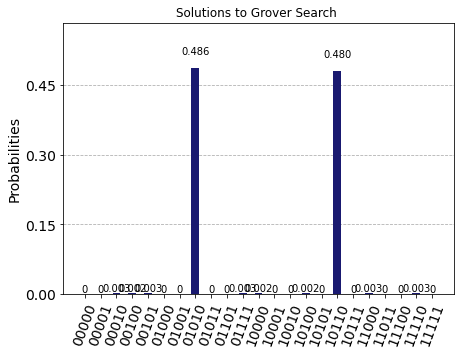

In [20]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(grover, backend)
plot_histogram(job.result().get_counts(), color='midnightblue', title="Solutions to Grover Search ")

## Solution:

The grover search correctly output the two solutions [01010] == [7,9] and [01101] == [7,8,1]

In this case the solutions were easily calculated and thus the oracle was implemented in this very specific way. However, in a more general manner the way the oracle is implemented through controlled phase gates can be leveraged to perform this search generally for any input array of numbers and desired integer output. For this, as mentioned, the oracle would have to be updated.

references:

- Quantum Computation and Quantum Information, Michael A. Nielsen, Isaac L. Chuang, Massachusetts Institute of Technology, 2010
- Addition on a Quantum Computer, Thomas G. Draper, June 15, 2000. (https://arxiv.org/pdf/quant-ph/0008033.pdf)
- https://qiskit.org/textbook/ch-algorithms/grover.html#5.2-Uncomputing,-and-Completing-the-Oracle
- https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html